### 🧠 What is Self-Reflection in RAG?
Self-reflection = LLM evaluates its own output:
“Is this clear, complete, and accurate?”

#### Self-Reflection in RAG using LangGraph, we’ll design a workflow where the agent:

1. Generates an initial answer using retrieved context
2. Reflects on that answer with a dedicated self-critic LLM step
3. If unsatisfied, it can revise the query, retrieve again, or regenerate the answer

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.faiss import FAISS
from langchain_community.document_loaders import TextLoader
from langgraph.graph import StateGraph, END

In [ ]:
### load llm models
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

In [4]:
docs = TextLoader("sample_docs.txt").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [5]:
# -------------------------
# 2. State Definition
# -------------------------
class RAGReflectionState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection: str = ""
    revised: bool = False
    attempts: int = 0

In [6]:
# -------------------------
# 3. Nodes
# -------------------------

# a. Retrieve
def retrieve_docs(state: RAGReflectionState) -> RAGReflectionState:
    docs = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs": docs})

# b. Generate Answer
def generate_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the following context to answer the question:

Context:
{context}
 
Question:
{state.question}
"""
    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": answer, "attempts": state.attempts + 1})

In [7]:
# c. Self-Reflect
def reflect_on_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    prompt = f"""
Reflect on the following answer to see if it fully addresses the question. 
State YES if it is complete and correct, or NO with an explanation.

Question: {state.question}

Answer: {state.answer}

Respond like:
Reflection: YES or NO
Explanation: ...
"""
    result = llm.invoke(prompt).content
    is_ok = "reflection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})

In [8]:
# d. Finalizer
def finalize(state: RAGReflectionState) -> RAGReflectionState:
    return state

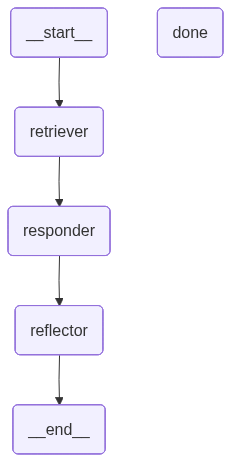

In [11]:
# -------------------------
# 4. LangGraph DAG
# -------------------------
builder = StateGraph(RAGReflectionState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")

builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")
builder.add_conditional_edges(
    "reflector",
    lambda s: "done" if not s.revised or s.attempts >= 2 else "retriever"
)

builder.add_edge("done", END)

graph = builder.compile()
graph

In [12]:
# -------------------------
# 5. Run the Agent
# -------------------------
if __name__ == "__main__":
    user_query = "What are the transformer variants in production deployments?"
    init_state = RAGReflectionState(question=user_query)
    result = graph.invoke(init_state)

    print("\n🧠 Final Answer:\n", result["answer"])
    print("\n🔁 Reflection Log:\n", result["reflection"])
    print("🔄 Total Attempts:", result["attempts"])


🧠 Final Answer:
 The question asks about transformer variants used in production deployments. Transformer models, derived from the original "Attention is All You Need" paper, have evolved into various specialized variants used in different environments. Some notable transformer variants that are commonly used or have been deployed in production include:

1. **BERT (Bidirectional Encoder Representations from Transformers)**: Primarily used for tasks requiring understanding of the context in natural language processing.

2. **GPT (Generative Pre-trained Transformer)**: Known for text generation tasks, with successive versions like GPT-2, GPT-3 offering improved capabilities in generating human-like text.

3. **T5 (Text-to-Text Transfer Transformer)**: A versatile model that treats various NLP tasks in a text-to-text framework, enabling flexible applications across different tasks.

4. **RoBERTa (A Robustly Optimized BERT Pretraining Approach)**: An enhanced version of BERT with improved